<h1>Experiment 2</h1>
<h2>Test the performance of the proposed methodology on motion-corrupted data</h2>
Import packages

In [ ]:
import nibabel as nib
import numpy as np
"""
packages that does conventional model fitting
"""
import amico
"""
packages that generate train/test dataset
"""
from FormatData import generate_data, parser as data_parser
"""
packages that trains network
"""
from Training import train_network
from utils.model import parser as model_parser
"""
packages that test network
"""
from Testing import test_model
"""
packages that produce the rejection shceme
"""
from filter_qa import parser as filter_parser, load_eddy

In [ ]:
class Namespace:
    """
    a class generate parser for cmd line args
    """
    def __init__(self, **kwargs):
        self.__dict__.update(kwargs)

In [ ]:
"""
packages that handle graphs
"""
import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm, LinearSegmentedColormap
from skimage.metrics import structural_similarity as compare_ssim
from utils import calc_ssim
%matplotlib inline
def plot_loss(cmd):
    """
    A function that used to plot the loss curve for the trained network.
    Args:
        cmd: String, the command line in the terminal
    """
    args = model_parser().parse_args(cmd.split())
    history = train_network(args)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

def show_slices(slices, grayscale=True):
    """
    Function to display the slices

    Args:
        slices (list): a list of 2d ndarray that contains the data to be displayed
        grayscale (bool, optional): True, if diplay grayscale img. Defaults to True.
    """    
    fig, axes = plt.subplots(1, len(slices), figsize=(10,10))
    cax = fig.add_axes([0, 0, .3, .3])
    for i, slice in enumerate(slices):
        # use grayscale for displaying ref and pred imgs:
        if grayscale:
            cmap = plt.get_cmap('gray')
            cmaplist = [cmap(i) for i in range(cmap.N)]
            cmap = LinearSegmentedColormap.from_list('Custom cmap', cmaplist, cmap.N)
            bounds = np.arange(0, 1.0, .01)
            idx = np.searchsorted(bounds, 0)
            bounds = np.insert(bounds, idx, 0)
            norm = BoundaryNorm(bounds, cmap.N)
            im = axes[i].imshow(slice.T, cmap=cmap, origin="lower", interpolation='none', norm=norm)
        else:
            # define the colormap
            cmap = plt.get_cmap('bwr')
            # extract all colors from the .jet map
            cmaplist = [cmap(i) for i in range(cmap.N)]
            # create the new map
            cmap = LinearSegmentedColormap.from_list('Custom cmap', cmaplist, cmap.N)
            # define the bins and normalize and forcing 0 to be part of the colorbar
            # define the min and max to be -1 and +1 respectively
            bounds = np.arange(-0.5, 0.5, .01)
            idx = np.searchsorted(bounds, 0)
            bounds = np.insert(bounds, idx, 0)
            norm = BoundaryNorm(bounds, cmap.N)
            im = axes[i].imshow(slice.T, cmap=cmap, origin="lower", interpolation='none', norm=norm)
        fig.colorbar(im, cax=cax, orientation='vertical')

def scale(img):
    # for i in range(img.shape[0]):
    #     for j in range(img.shape[1]):
    #         img[i][j] = ((img[i][j]+1)/2)*255
    return img

def compare_simi(pred, ref):
    return calc_ssim(pred, ref)

In [ ]:
def visualise(ref_ndi, ref_odi, ref_fwf, retained_vol, subject, model, layer, affine1, affine2, affine3):
    """
    Function to visualise the imgs and difference maps

    Args:
        ref_ndi (ndarray): the reference NDI data
        ref_odi (ndarray): the reference ODI data
        ref_fwf (ndarray): the reference FWF data
        retained_vol (int): the number of volumes retained after rejection
        subject (string): the subject that is examined
        model (string): the model used
        layer (int): the number of layers for the network
    """
    patch = 3
    if model == 'fc1d':
        patch = 1

    print(patch)
    print(model)
    # visualise the ref imgs
    refNDI0 = ref_ndi[26, :, :]
    refNDI1 = ref_ndi[:, 30, :]
    refNDI2 = ref_ndi[:, :, 16]
    show_slices([refNDI0, refNDI1, refNDI2])
    plt.suptitle("Center slices for NDI reference image")

    refODI0 = ref_odi[26, :, :]
    refODI1 = ref_odi[:, 30, :]
    refODI2 = ref_odi[:, :, 16]
    show_slices([refODI0, refODI1, refODI2])
    plt.suptitle("Center slices for ODI reference image")

    refFWF0 = ref_fwf[26, :, :]
    refFWF1 = ref_fwf[:, 30, :]
    refFWF2 = ref_fwf[:, :, 16]
    show_slices([refFWF0, refFWF1, refFWF2])
    plt.suptitle("Center slices for FWF reference image")

    # visualise the pred imgs produced at varied input size
    ndi_path = '../Net/nii/'+subject+'-'+str(retained_vol)+'-'+model+'-patch_'+str(patch)+'-base_1-layer_'+str(layer)+'-label_NDI.nii'
    odi_path = '../Net/nii/'+subject+'-'+str(retained_vol)+'-'+model+'-patch_'+str(patch)+'-base_1-layer_'+str(layer)+'-label_ODI.nii'
    fwf_path = '../Net/nii/'+subject+'-'+str(retained_vol)+'-'+model+'-patch_'+str(patch)+'-base_1-layer_'+str(layer)+'-label_FWF.nii'
    ndi_img = nib.load(ndi_path)
    ndi_data = ndi_img.get_fdata()
    odi_img = nib.load(odi_path)
    odi_data = odi_img.get_fdata()
    fwf_img = nib.load(fwf_path)
    fwf_data = fwf_img.get_fdata()

    ndi0 = ndi_data[26, :, :]
    ndi1 = ndi_data[:, 30, :]
    ndi2 = ndi_data[:, :, 16]
    show_slices([ndi0, ndi1, ndi2])
    plt.suptitle('Center slices for NDI predicted image by '+model+', input size='+str(retained_vol))
    (score, ndidiff) = compare_ssim(ndi_data, ref_ndi, full=True)
    print(str(retained_vol)+'input size the ssim score for ndi is: ' + str(score))

    odi0 = odi_data[26, :, :]
    odi1 = odi_data[:, 30, :]
    odi2 = odi_data[:, :, 16]
    show_slices([odi0, odi1, odi2])
    plt.suptitle('Center slices for ODI predicted image by '+model+', input size='+str(retained_vol))
    (score, odidiff) = compare_ssim(odi_data, ref_odi, full=True)
    print(str(retained_vol)+'input size the ssim score for odi is: ' + str(score))

    fwf0 = fwf_data[26, :, :]
    fwf1 = fwf_data[:, 30, :]
    fwf2 = fwf_data[:, :, 16]
    show_slices([fwf0, fwf1, fwf2])
    plt.suptitle('Center slices for FWF predicted image by '+model+', input size='+str(retained_vol))
    (score, fwfdiff) = compare_ssim(fwf_data, ref_fwf, full=True)
    print(str(retained_vol)+'input size the ssim score for fwf is: ' + str(score))

    # plot the difference map between the imgs by the lib
    ndidiff0 = scale(refNDI0 - ndi0)
    ndidiff1 = scale(refNDI1 - ndi1)
    ndidiff2 = scale(refNDI2 - ndi2)
    show_slices([ndidiff0, ndidiff1, ndidiff2], grayscale=False)
    plt.suptitle("Difference map NDI")

    diff_img_np = ref_ndi - ndi_data
    diff_img = nib.Nifti1Image(diff_img_np, affine1)
    nib.save(diff_img, '../Net/nii/'+subject+'-'+str(retained_vol)+'-'+model+'-patch_'+str(patch)+'-base_1-layer_'+str(layer)+'-label_NDI_difference.nii')

    odidiff0 = scale(refODI0 - odi0)
    odidiff1 = scale(refODI1 - odi1)
    odidiff2 = scale(refODI2 - odi2)
    show_slices([odidiff0, odidiff1, odidiff2], grayscale=False)
    plt.suptitle("Difference map ODI")

    diff_img_np = ref_odi - odi_data
    diff_img = nib.Nifti1Image(diff_img_np, affine2)
    nib.save(diff_img, '../Net/nii/'+subject+'-'+str(retained_vol)+'-'+model+'-patch_'+str(patch)+'-base_1-layer_'+str(layer)+'-label_ODI_difference.nii')

    fwfdiff0 = scale(refFWF0 - fwf0)
    fwfdiff1 = scale(refFWF1 - fwf1)
    fwfdiff2 = scale(refFWF2 - fwf2)
    show_slices([fwfdiff0, fwfdiff1, fwfdiff2], grayscale=False)
    plt.suptitle("Difference map FWF")

    diff_img_np = ref_fwf - fwf_data
    diff_img = nib.Nifti1Image(diff_img_np, affine3)
    nib.save(diff_img, '../Net/nii/'+subject+'-'+str(retained_vol)+'-'+model+'-patch_'+str(patch)+'-base_1-layer_'+str(layer)+'-label_FWF_difference.nii')

<h3>Data Preprocessing</h3>

In [ ]:
# motion-free subject path
s01_path = '/home/vw/Desktop/IndividualProject/MedICSS2021_/Data-NODDI/s01_still/'
s02_path = '/home/vw/Desktop/IndividualProject/MedICSS2021_/Data-NODDI/s02_still/'
s03_path = '/home/vw/Desktop/IndividualProject/MedICSS2021_/Data-NODDI/s03_still_reg/'
s04_path = '/home/vw/Desktop/IndividualProject/MedICSS2021_/Data-NODDI/s04_still_reg/'
# motion-free target labels
s01_NDI_path = '/home/vw/Desktop/IndividualProject/MedICSS2021_/Data-NODDI/s01_still/s01_still_NDI.nii'
s02_NDI_path = '/home/vw/Desktop/IndividualProject/MedICSS2021_/Data-NODDI/s02_still/s02_still_NDI.nii'
s03_NDI_path = '/home/vw/Desktop/IndividualProject/MedICSS2021_/Data-NODDI/s03_still_reg/s03_still_reg_NDI.nii'
s04_NDI_path = '/home/vw/Desktop/IndividualProject/MedICSS2021_/Data-NODDI/s04_still_reg/s04_still_reg_NDI.nii'

s01_ODI_path = '/home/vw/Desktop/IndividualProject/MedICSS2021_/Data-NODDI/s01_still/s01_still_ODI.nii'
s02_ODI_path = '/home/vw/Desktop/IndividualProject/MedICSS2021_/Data-NODDI/s02_still/s02_still_ODI.nii'
s03_ODI_path = '/home/vw/Desktop/IndividualProject/MedICSS2021_/Data-NODDI/s03_still_reg/s03_still_reg_ODI.nii'
s04_ODI_path = '/home/vw/Desktop/IndividualProject/MedICSS2021_/Data-NODDI/s04_still_reg/s04_still_reg_ODI.nii'

s01_FWF_path = '/home/vw/Desktop/IndividualProject/MedICSS2021_/Data-NODDI/s01_still/s01_still_FWF.nii'
s02_FWF_path = '/home/vw/Desktop/IndividualProject/MedICSS2021_/Data-NODDI/s02_still/s02_still_FWF.nii'
s03_FWF_path = '/home/vw/Desktop/IndividualProject/MedICSS2021_/Data-NODDI/s03_still_reg/s03_still_reg_FWF.nii'
s04_FWF_path = '/home/vw/Desktop/IndividualProject/MedICSS2021_/Data-NODDI/s04_still_reg/s04_still_reg_FWF.nii'

In [ ]:
def filter_mask(subpath, fwfpath, threshold=0.99):
    """
    By looking at the imgs generated, we have found out there are some regions that should not be included. Since they have values higher than 1.0
    And we have found out voxels have NDI and ODI values, while that voxel has GROUND TRUTH FWF 1.0
    This should indicate that that voxel should not even be included in the training
    Therefore we want to filter the each subject's mask first, by using their corresponding GROUND TRUTH FWF

    Args:
        subpath (string): the path of the subject folder
        fwfpath (string): the path of the corresponding fwf file
        threshold (float): the thresholds to be used to filter of the mask,
                           a stringnent threshold would be 0.9, the least stringnent threshold is 1.0
                           by default, it is set to 0.99
    """
    # fetch the mask data
    img_mask = nib.load(subpath+'mask-e.nii')
    original_mask = img_mask.get_fdata()
    original_affine = img_mask.affine
    shape = original_mask.shape # retain the shape of the mask
    origin_nonzeros = np.count_nonzero(original_mask)
    print('original mask has: ' + str(origin_nonzeros) + ' of nonzero voxels')
    # fetch the FWF data
    fwf = nib.load(fwfpath).get_fdata()
    # filter
    mask = original_mask.flatten() # this makes a copy of the orginal mask
    fwf = fwf.reshape(mask.shape[0]) # reshape fwf to the corresponding shape
    for i in range(len(mask)):
        # if fwf has high value, means there is no tissue
        # therefore, the voxel should be excluded
        if fwf[i] >= threshold:
            mask[i] = 0.0
    # reshape mask back
    mask = mask.reshape(shape)
    filter_nonzeros = np.count_nonzero(mask)
    print('filtered mask has: ' +str(filter_nonzeros) + ' of nonzero voxels')
    # save the mask
    filter_img = nib.Nifti1Image(mask, original_affine)
    nib.save(filter_img, subpath+'filtered_mask.nii')

In [ ]:
# Use the above code to filter each subject's mask. Store as filtered_mask.nii in each subject folder
filter_mask(s01_path, s01_FWF_path)
filter_mask(s02_path, s02_FWF_path)
filter_mask(s03_path, s04_FWF_path)
filter_mask(s04_path, s03_FWF_path)

In [ ]:
# filtered mask path for each subject
s01_mask_path = '/home/vw/Desktop/IndividualProject/MedICSS2021_/Data-NODDI/s01_still/filtered_mask.nii'
s02_mask_path = '/home/vw/Desktop/IndividualProject/MedICSS2021_/Data-NODDI/s02_still/filtered_mask.nii'
s03_mask_path = '/home/vw/Desktop/IndividualProject/MedICSS2021_/Data-NODDI/s03_still_reg/filtered_mask.nii'
s04_mask_path = '/home/vw/Desktop/IndividualProject/MedICSS2021_/Data-NODDI/s04_still_reg/filtered_mask.nii'

In [ ]:
"""
Generate the base dataset for s01_still, s02_still, s03_still_reg and s04_still_reg first for all NODDI parameters.
"""
cmd = "--base --label_type A --subjects s01_still s02_still s03_still_reg s04_still_reg"
args = data_parser().parse_args(cmd.split())
generate_data(args)

In [ ]:
"""
Using nib to fetch the ground truth img
"""
#load the truth data for subject 1
s01_NDI_img = nib.load(s01_NDI_path)
s01_ODI_img = nib.load(s01_ODI_path)
s01_FWF_img = nib.load(s01_FWF_path)
s01_NDI_affine = s01_NDI_img.affine
s01_ODI_affine = s01_ODI_img.affine
s01_FWF_affine = s01_FWF_img.affine
s01_NDI_img_data = s01_NDI_img.get_fdata()
s01_ODI_img_data = s01_ODI_img.get_fdata()
s01_FWF_img_data = s01_FWF_img.get_fdata()
#load the truth data for subject 2
s02_NDI_img = nib.load(s02_NDI_path)
s02_ODI_img = nib.load(s02_ODI_path)
s02_FWF_img = nib.load(s02_FWF_path)
s02_NDI_affine = s02_NDI_img.affine
s02_ODI_affine = s02_ODI_img.affine
s02_FWF_affine = s02_FWF_img.affine
s02_NDI_img_data = s02_NDI_img.get_fdata()
s02_ODI_img_data = s02_ODI_img.get_fdata()
s02_FWF_img_data = s02_FWF_img.get_fdata()
# load the truth data for subject 3
s03_NDI_img = nib.load(s03_NDI_path)
s03_ODI_img = nib.load(s03_ODI_path)
s03_FWF_img = nib.load(s03_FWF_path)
s03_NDI_affine = s03_NDI_img.affine
s03_ODI_affine = s03_ODI_img.affine
s03_FWF_affine = s03_FWF_img.affine
s03_NDI_img_data = s03_NDI_img.get_fdata()
s03_ODI_img_data = s03_ODI_img.get_fdata()
s03_FWF_img_data = s03_FWF_img.get_fdata()
# load the truth data for subject 4
s04_NDI_img = nib.load(s04_NDI_path)
s04_ODI_img = nib.load(s04_ODI_path)
s04_FWF_img = nib.load(s04_FWF_path)
s04_NDI_affine = s04_NDI_img.affine
s04_ODI_affine = s04_ODI_img.affine
s04_FWF_affine = s04_FWF_img.affine
s04_NDI_img_data = s04_NDI_img.get_fdata()
s04_ODI_img_data = s04_ODI_img.get_fdata()
s04_FWF_img_data = s04_FWF_img.get_fdata()

We will be using the proposed networks, 4 layer ANN, 2D CNN and 3D CNN, to carry out this experiment. The networks are required to be trained again, since this time we will use the rejection scheme to select the input DWI rather than using the sequential scheme.<br/>
To use the rejection scheme, we are firstly required to use filter_qa.py to set up the thresholds to obtain the retained volumes.<br/>
<h4>Filtering the data</h4><br/>
To filter the data, user needs to provide the path for s03_motion and s04_motion, by that filter_qa can access the QAfrom-eddylog.txt. Using the thresholds set by the users, the code could produce a rejection scheme file that has binary values in it. Where 1 represents the one has motion-level below the thresholds; whereas 0 represents the one has higher motion-level than the thresholds. Hence, when the rejection scheme is applied to the (training/testing) datasets, the code would select the volumes having corresponding 1s in the scheme.


In [69]:
# filter the motion data
s03_path = '/home/vw/Desktop/IndividualProject/MedICSS2021_/Data-NODDI/s03_motion' # the path of subject 3 motion
s04_path = '/home/vw/Desktop/IndividualProject/MedICSS2021_/Data-NODDI/s04_motion' # the path of subject 3 motion
# set the thresholds, and the number of DWIs to be examined. THe thresholds are all float numbers
# stringnet thresholds are used t0=Absolute Translation, t1=Relative Translation, r0=Absolute Rotation, r1=Relative Rotation and out=Fractional Signal Dropouts
t0, t1, r0, r1, out, num = 10.0, 5.0, 10.0, 5.0, 0.20, 96 
# produce the filter cmd and args
filter_cmd = '--path ' + s03_path + ' --t0 ' + str(t0) + ' --t1 ' + str(t1) + ' --r0 ' + str(r0) + ' --r1 ' + str(r1) + ' --out ' + str(out) + ' --num ' + str(num)
filter_args = filter_parser().parse_args(filter_cmd.split())
# this should generate move_t0-{t0}_t1-{t1}_r0-{r0}_r1-{r1}_out-{out}.txt file in the path of subject 3 motion for s03 first
load_eddy(filter_args)

filter_cmd = '--path ' + s04_path + ' --t0 ' + str(t0) + ' --t1 ' + str(t1) + ' --r0 ' + str(r0) + ' --r1 ' + str(r1) + ' --out ' + str(out) + ' --num ' + str(num)
filter_args = filter_parser().parse_args(filter_cmd.split())
# rejection scheme for s04 is generated
load_eddy(filter_args)

# the path of the rejection schemes
s03_movefile = s03_path + '/move_t0-'+str(t0)+'_t1-'+str(t1)+'_r0-'+str(r0)+'_r1-'+str(r1)+'_out-'+str(out)+'.txt'
s04_movefile = s04_path + '/move_t0-'+str(t0)+'_t1-'+str(t1)+'_r0-'+str(r0)+'_r1-'+str(r1)+'_out-'+str(out)+'.txt'

<h4>Training</h4><br/>
Now, we will use the rejection scheme we have, to fetch the training data for training our proposed networks.<br/>
Firstly, we will define the hyperparameters that will be used for all proposed networks

In [ ]:
# hyperparameters for the networks
layers = 5 # the number of hidden layers; this is the optimal number of layer
lr = 0.0001 # the learning rate
patch_size = 3 # the size of patches for 2D and 3D CNN
batch = 256 # the batch size
epoch = 100 # the number of epoches for training
ltype = 'A' # the NODDI parameter we want to estimate, where A stands for ALL

___
<strong>ANN</strong>

In [ ]:
model = 'fc1d'
# firstly, the ann dataset is required to be generated.
# the cmd line code for generating ANN data
anndata_cmd = '--subjects s01_still s02_still s03_still_reg s04_still_reg' + ' --label_type ' + ltype + ' --' + model
anndata_args  = data_parser().parse_args(anndata_cmd.split())
# this should produce s01_still-base1-patches-1d-1-1-all.mat ... s04_still_reg-base1-patches-1d-1-1-all.mat under Net/datasets/data
generate_data(anndata_args)

In [ ]:
# we firstly study subject s03, by using s01 as a seperate training dataset
study_subject = 's03_still_reg' # the subject we want to study
sep_train_subject = 's01_still' # this is separate training candidate
# the cmd line code for training, we will apply the rejection scheme from study_subject to the separate training dataset
anntrain_cmd = '--train_subjects ' + sep_train_subject + ' --model ' + model + ' --layer ' + str(layers) + ' --label_type ' + ltype + ' --lr ' + str(lr) + ' --batch ' + str(batch) + ' --patch_size ' + str(patch_size)\
               + ' --epoch ' + str(epoch) + ' --movefile ' + s03_movefile + ' --train'
# train ANN and plot the loss curve
plot_loss(anntrain_cmd)

In [ ]:
# We have trained ANN by using a desired subset of a separate training dataset. We would like to apply this model onto the remained volumes of study subject
# the cmd line code for testing
anntest_cmd = '--test_subjects ' + study_subject + ' --model ' + model + ' --layer ' + str(layers) + ' --label_type ' + ltype + ' --movefile ' + s03_movefile
anntest_args = model_parser().parse_args(anntest_cmd.split())
# test
test_model(anntest_args)

In [ ]:
# visualise the predicted NODDI parameters
vol = 29 # the number of volumes remained after rejection scheme is applied
visualise(s03_NDI_img_data, s03_ODI_img_data, s03_FWF_img_data, retained_vol=vol,subject=study_subject, model=model, layer=layers,affine1=s03_NDI_affine, affine2=s03_ODI_affine, affine3=s03_FWF_affine)

In [ ]:
# repeat the same process for subject 4
study_subject = 's04_still_reg' # this is the name of the study subject
sep_train_subject = 's01_still' # this is the name of the separate training candidate
# we use the rejection scheme produced from the study subject to select the desired subset from the separate training dataset. And we train on the separate training dataset
anntrain_cmd = '--train_subjects ' + sep_train_subject + ' --model ' + model + ' --layer ' + str(layers) + ' --label_type ' + ltype + ' --lr ' + str(lr) + ' --batch ' + str(batch) + ' --patch_size ' + str(patch_size)\
               + ' --epoch ' + str(epoch) + ' --movefile ' + s04_movefile + ' --train'
# train ANN and plot the loss curve
plot_loss(anntrain_cmd)

In [ ]:
# We have trained ANN by using a desired subset of a separate training dataset. We would like to apply this model onto the remained volumes of study subject
# the cmd line code for testing
anntest_cmd = '--test_subjects ' + study_subject + ' --model ' + model + ' --layer ' + str(layers) + ' --label_type ' + ltype + ' --movefile ' + s04_movefile
anntest_args = model_parser().parse_args(anntest_cmd.split())
# test
test_model(anntest_args)

In [ ]:
# visualise the predicted NODDI parameters
vol = 10 # the number of volumes remained after rejection scheme is applied
visualise(s04_NDI_img_data, s04_ODI_img_data, s04_FWF_img_data, retained_vol=vol,subject=study_subject, model=model, layer=layers, affine1=s04_NDI_affine, affine2=s04_ODI_affine, affine3=s04_FWF_affine)

___
<strong>2D CNN</strong>

In [ ]:
model = 'conv2d'
# firstly, the 2d cnn dataset is required to be generated.
# the cmd line code for generating 2d cnn data
cnn2ddata_cmd = '--subjects s01_still s02_still s03_still_reg s04_still_reg' + ' --label_type ' + ltype + ' --' + model
cnn2ddata_args  = data_parser().parse_args(cnn2ddata_cmd.split())
# this should produce s01_still-base1-patches-2d-3-1-all.mat ... s04_still_reg-base1-patches-3d-3-1-all.mat under Net/datasets/data
generate_data(cnn2ddata_args)

In [ ]:
# we firstly study subject s03, by using s01 as a seperate training dataset
study_subject = 's03_still_reg' # the subject we want to study
sep_train_subject = 's01_still' # this is separate training candidate
# the cmd line code for training, we will apply the rejection scheme from study_subject to the separate training dataset
cnn2dtrain_cmd = '--train_subjects ' + sep_train_subject + ' --model ' + model + ' --layer ' + str(layers) + ' --label_type ' + ltype + ' --lr ' + str(lr) + ' --batch ' + str(batch) + ' --patch_size ' + str(patch_size)\
               + ' --epoch ' + str(epoch) + ' --movefile ' + s03_movefile + ' --train'
# train 2d cnn and plot the loss curve
plot_loss(cnn2dtrain_cmd)

In [ ]:
# We have trained 2d cnn by using a desired subset of a separate training dataset. We would like to apply this model onto the remained volumes of study subject
# the cmd line code for testing
cnn2dtest_cmd = '--test_subjects ' + study_subject + ' --model ' + model + ' --layer ' + str(layers) + ' --label_type ' + ltype + ' --movefile ' + s03_movefile
cnn2dtest_args = model_parser().parse_args(cnn2dtest_cmd.split())
# test
test_model(cnn2dtest_args)

In [ ]:
# visualise the predicted NODDI parameters
vol = 29 # the number of volumes remained after rejection scheme is applied
visualise(s03_NDI_img_data, s03_ODI_img_data, s03_FWF_img_data, retained_vol=vol,subject=study_subject, model=model, layer=layers, affine1=s03_NDI_affine, affine2=s03_ODI_affine, affine3=s03_FWF_affine)

In [ ]:
# repeat the process for study subject s04
# we study subject s04, by using s01 as a seperate training dataset
study_subject = 's04_still_reg' # the subject we want to study
sep_train_subject = 's01_still' # this is separate training candidate
# the cmd line code for training, we will apply the rejection scheme from study_subject to the separate training dataset
cnn2dtrain_cmd = '--train_subjects ' + sep_train_subject + ' --model ' + model + ' --layer ' + str(layers) + ' --label_type ' + ltype + ' --lr ' + str(lr) + ' --batch ' + str(batch) + ' --patch_size ' + str(patch_size)\
               + ' --epoch ' + str(epoch) + ' --movefile ' + s04_movefile + ' --train'
# train ANN and plot the loss curve
plot_loss(cnn2dtrain_cmd)

In [ ]:
# We have trained 2d cnn by using a desired subset of a separate training dataset. We would like to apply this model onto the remained volumes of study subject
# the cmd line code for testing
cnn2dtest_cmd = '--test_subjects ' + study_subject + ' --model ' + model + ' --layer ' + str(layers) + ' --label_type ' + ltype + ' --movefile ' + s04_movefile
cnn2dtest_args = model_parser().parse_args(cnn2dtest_cmd.split())
# test
test_model(cnn2dtest_args)

In [ ]:
# visualise the predicted NODDI parameters
vol = 10 # the number of volumes remained after rejection scheme is applied
visualise(s04_NDI_img_data, s04_ODI_img_data, s04_FWF_img_data, retained_vol=vol,subject=study_subject, model=model, layer=layers, affine1=s04_NDI_affine, affine2=s04_ODI_affine, affine3=s04_FWF_affine)

___
<strong>3D CNN</strong>

In [ ]:
model = 'conv3d'
# firstly, the 3d cnn dataset is required to be generated.
# the cmd line code for generating 3d cnn data
cnn3ddata_cmd = '--subjects s01_still s02_still s03_still_reg s04_still_reg' + ' --label_type ' + ltype + ' --' + model
cnn3ddata_args  = data_parser().parse_args(cnn3ddata_cmd.split())
# this should produce s01_still-base1-patches-3d-3-1-all.mat ... s04_still_reg-base1-patches-3d-3-1-all.mat under Net/datasets/data
generate_data(cnn3ddata_args)

93
Model: "functional_51"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_18 (InputLayer)        [(None, 3, 3, 3, 93)]     0         
_________________________________________________________________
conv3d_102 (Conv3D)          (None, 1, 1, 1, 150)      376800    
_________________________________________________________________
conv3d_103 (Conv3D)          (None, 1, 1, 1, 150)      22650     
_________________________________________________________________
conv3d_104 (Conv3D)          (None, 1, 1, 1, 150)      22650     
_________________________________________________________________
conv3d_105 (Conv3D)          (None, 1, 1, 1, 150)      22650     
_________________________________________________________________
conv3d_106 (Conv3D)          (None, 1, 1, 1, 150)      22650     
_________________________________________________________________
dropout_17 (Dropout)         (None, 1, 1, 1, 150) 

2022-04-04 20:56:37.885634: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2022-04-04 20:56:37.885713: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1513] CUPTI activity buffer flushed


2022-04-04 20:56:38.548302: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2022-04-04 20:56:38.573077: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1513] CUPTI activity buffer flushed
2022-04-04 20:56:38.573356: I tensorflow/core/profiler/internal/gpu/device_tracer.cc:223]  GpuTracer has collected 0 callback api events and 0 activity events. 
2022-04-04 20:56:38.574521: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: logs/train/plugins/profile/2022_04_04_20_56_38
2022-04-04 20:56:38.575085: I tensorflow/core/profiler/rpc/client/save_profile.cc:182] Dumped gzipped tool data for trace.json.gz to logs/train/plugins/profile/2022_04_04_20_56_38/vw.trace.json.gz
2022-04-04 20:56:38.575169: E tensorflow/core/profiler/utils/hardware_type_utils.cc:61] Invalid GPU compute capability.
2022-04-04 20:56:38.576145: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: logs/train/plugins/profile/2022

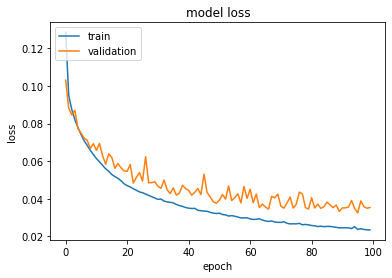

In [70]:
# we firstly study subject s03, by using s01 as a seperate training dataset
study_subject = 's03_still_reg' # the subject we want to study
sep_train_subject = 's01_still' # this is separate training candidate
# the cmd line code for training, we will apply the rejection scheme from study_subject to the separate training dataset
cnn3dtrain_cmd = '--train_subjects ' + sep_train_subject + ' --model ' + model + ' --layer ' + str(layers) + ' --label_type ' + ltype + ' --lr ' + str(lr) + ' --batch ' + str(batch) + ' --patch_size ' + str(patch_size)\
               + ' --epoch ' + str(epoch) + ' --movefile ' + s03_movefile + ' --train'
# train 3d cnn and plot the loss curve
plot_loss(cnn3dtrain_cmd)

In [71]:
# We have trained 3d cnn by using a desired subset of a separate training dataset. We would like to apply this model onto the remained volumes of study subject
# the cmd line code for testing
cnn3dtest_cmd = '--test_subjects ' + study_subject + ' --model ' + model + ' --layer ' + str(layers) + ' --label_type ' + ltype + ' --movefile ' + s03_movefile
cnn3dtest_args = model_parser().parse_args(cnn3dtest_cmd.split())
# test
test_model(cnn3dtest_args)

93-conv3d-patch_3-base_1-layer_5-label_NDIODIFWF
(84, 84, 50)
Model: "functional_55"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_19 (InputLayer)        [(None, 84, 84, 50, 93)]  0         
_________________________________________________________________
conv3d_108 (Conv3D)          (None, 82, 82, 48, 150)   376800    
_________________________________________________________________
conv3d_109 (Conv3D)          (None, 82, 82, 48, 150)   22650     
_________________________________________________________________
conv3d_110 (Conv3D)          (None, 82, 82, 48, 150)   22650     
_________________________________________________________________
conv3d_111 (Conv3D)          (None, 82, 82, 48, 150)   22650     
_________________________________________________________________
conv3d_112 (Conv3D)          (None, 82, 82, 48, 150)   22650     
_________________________________________________________

3
conv3d
93input size the ssim score for ndi is: 0.956786042960662
93input size the ssim score for odi is: 0.9644180360908357
93input size the ssim score for fwf is: 0.9778509361159857


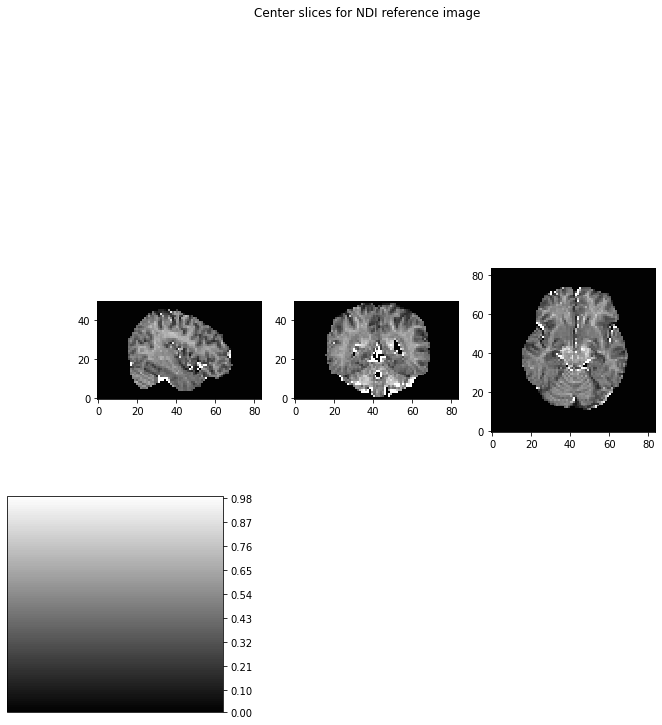

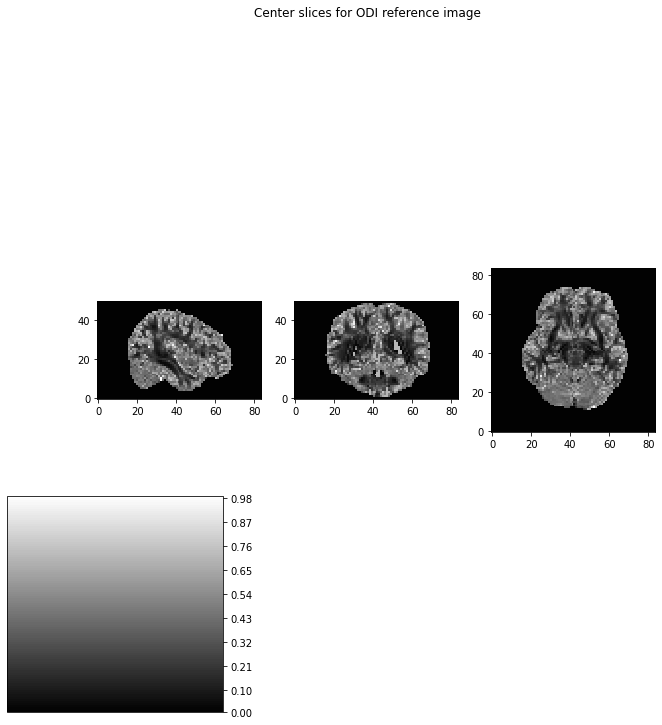

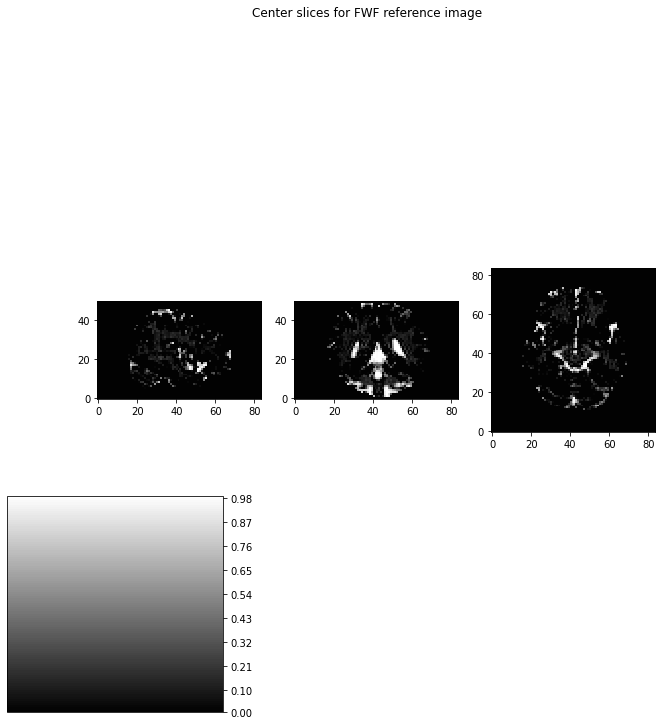

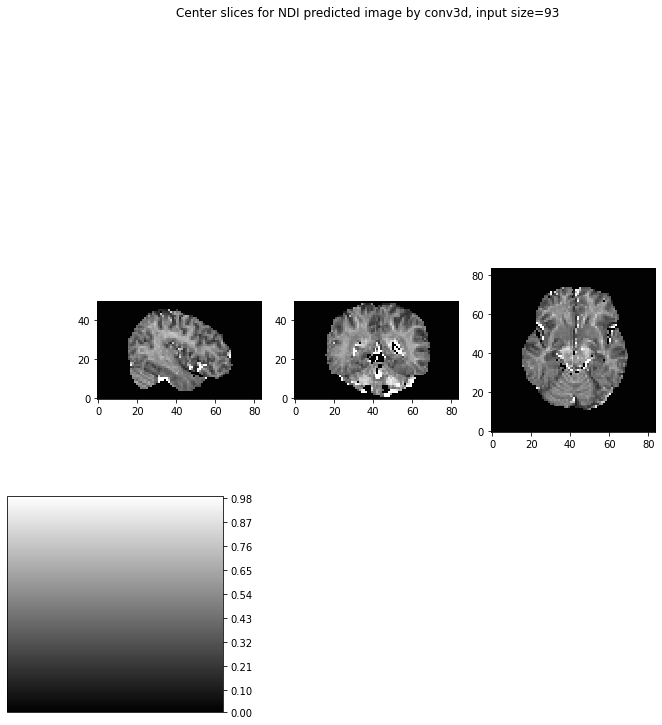

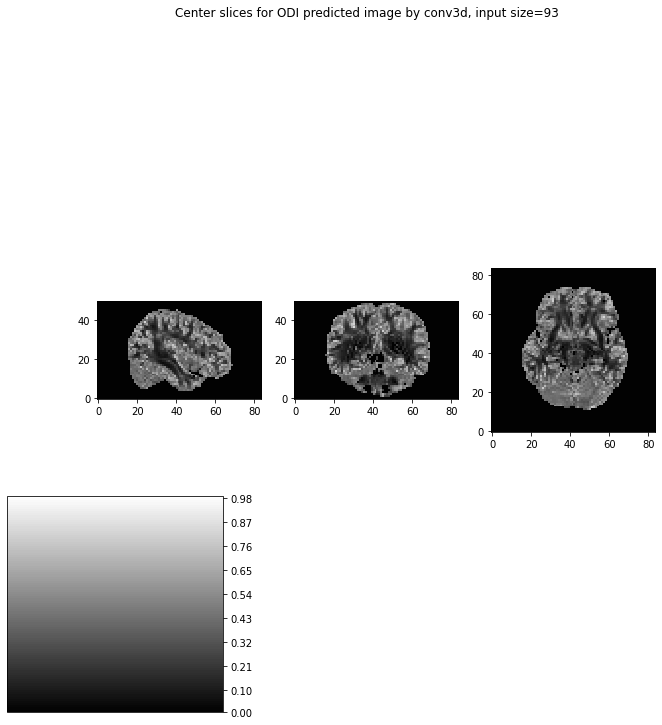

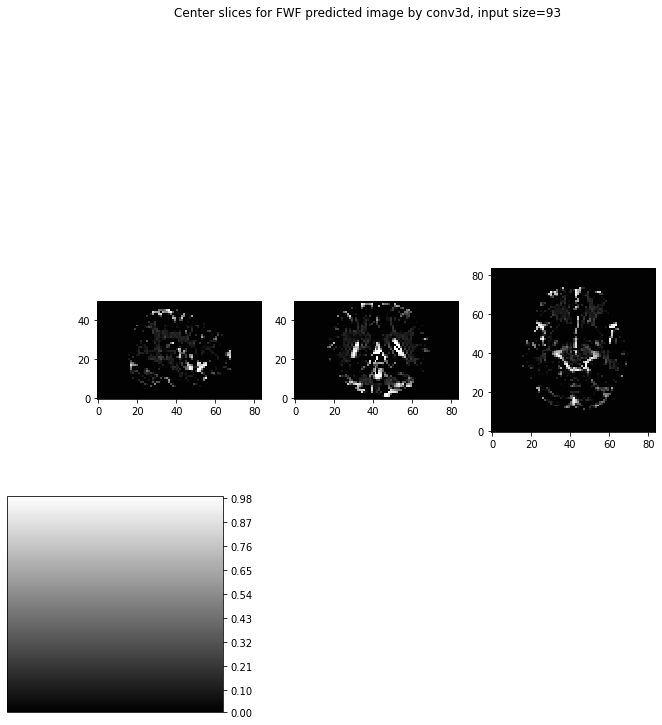

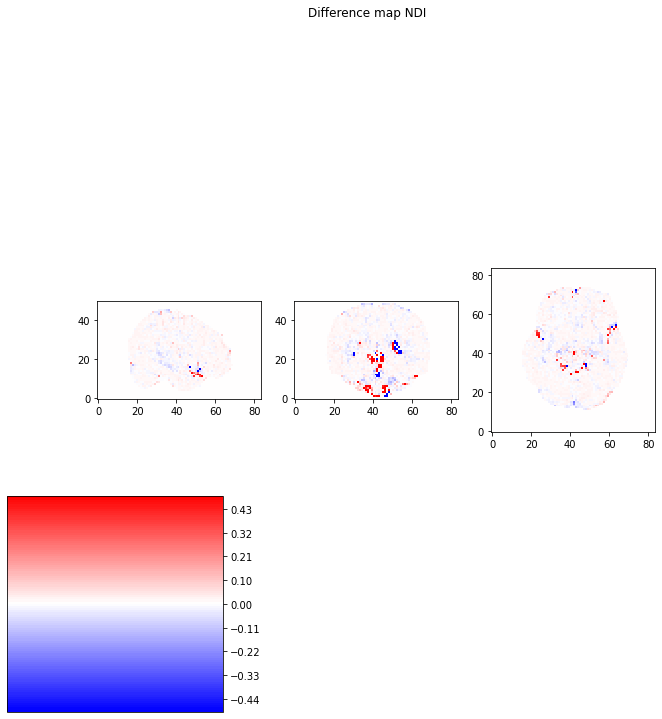

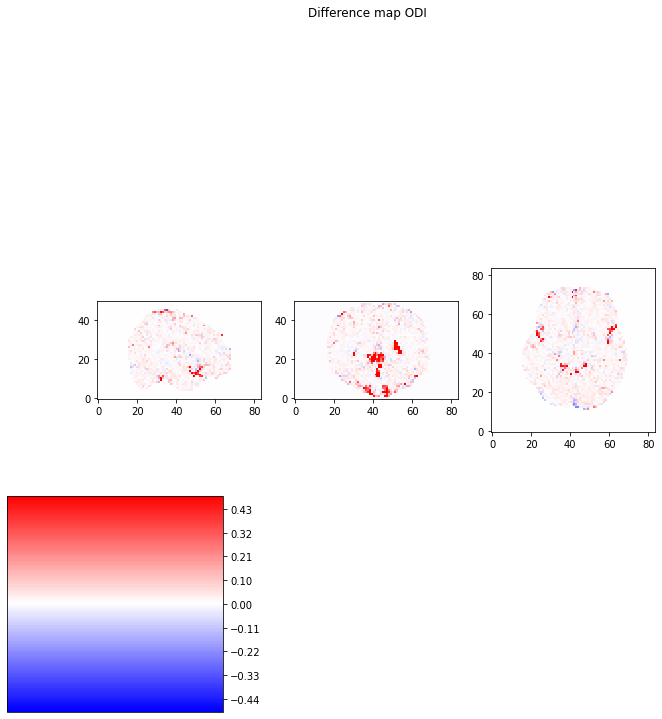

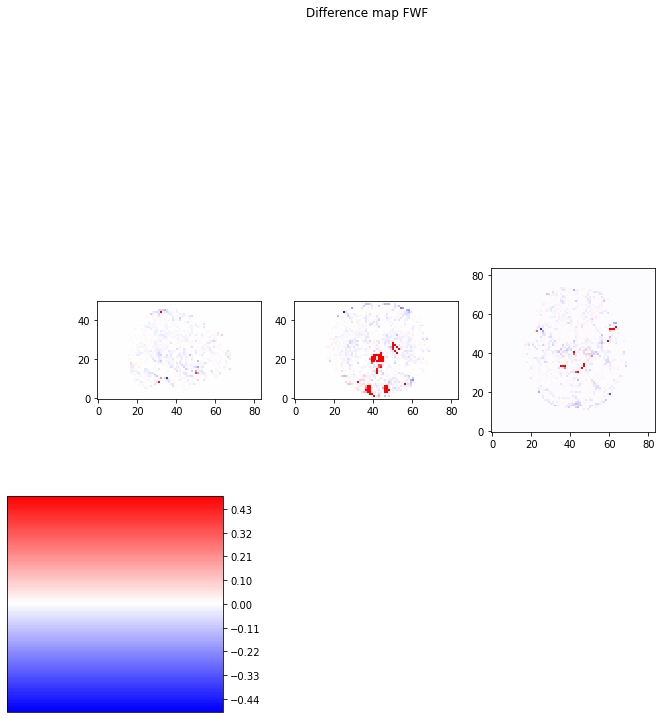

In [73]:
# visualise the predicted NODDI parameters
vol = 93 # the number of volumes remained after rejection scheme is applied
visualise(s03_NDI_img_data, s03_ODI_img_data, s03_FWF_img_data, retained_vol=vol,subject=study_subject, model=model, layer=layers, affine1=s03_NDI_affine, affine2=s03_ODI_affine, affine3=s03_FWF_affine)

64
Model: "functional_57"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_20 (InputLayer)        [(None, 3, 3, 3, 64)]     0         
_________________________________________________________________
conv3d_114 (Conv3D)          (None, 1, 1, 1, 150)      259350    
_________________________________________________________________
conv3d_115 (Conv3D)          (None, 1, 1, 1, 150)      22650     
_________________________________________________________________
conv3d_116 (Conv3D)          (None, 1, 1, 1, 150)      22650     
_________________________________________________________________
conv3d_117 (Conv3D)          (None, 1, 1, 1, 150)      22650     
_________________________________________________________________
conv3d_118 (Conv3D)          (None, 1, 1, 1, 150)      22650     
_________________________________________________________________
dropout_19 (Dropout)         (None, 1, 1, 1, 150) 

2022-04-04 21:00:17.193150: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2022-04-04 21:00:17.193236: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1513] CUPTI activity buffer flushed


2022-04-04 21:00:17.735512: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2022-04-04 21:00:17.760334: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1513] CUPTI activity buffer flushed
2022-04-04 21:00:17.760619: I tensorflow/core/profiler/internal/gpu/device_tracer.cc:223]  GpuTracer has collected 0 callback api events and 0 activity events. 
2022-04-04 21:00:17.761787: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: logs/train/plugins/profile/2022_04_04_21_00_17
2022-04-04 21:00:17.762361: I tensorflow/core/profiler/rpc/client/save_profile.cc:182] Dumped gzipped tool data for trace.json.gz to logs/train/plugins/profile/2022_04_04_21_00_17/vw.trace.json.gz
2022-04-04 21:00:17.762431: E tensorflow/core/profiler/utils/hardware_type_utils.cc:61] Invalid GPU compute capability.
2022-04-04 21:00:17.763315: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: logs/train/plugins/profile/2022

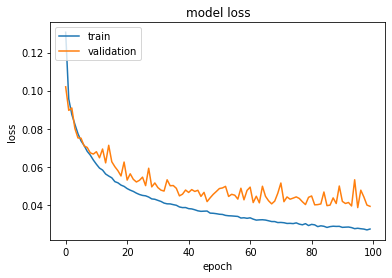

In [74]:
# repeat the same process for subject 4
# we study subject s04, by using s01 as a seperate training dataset
study_subject = 's04_still_reg' # the subject we want to study
sep_train_subject = 's01_still' # this is separate training candidate
# the cmd line code for training, we will apply the rejection scheme from study_subject to the separate training dataset
cnn3dtrain_cmd = '--train_subjects ' + sep_train_subject + ' --model ' + model + ' --layer ' + str(layers) + ' --label_type ' + ltype + ' --lr ' + str(lr) + ' --batch ' + str(batch) + ' --patch_size ' + str(patch_size)\
               + ' --epoch ' + str(epoch) + ' --movefile ' + s04_movefile + ' --train'
# train 3d cnn and plot the loss curve
plot_loss(cnn3dtrain_cmd)

In [75]:
# We have trained 3d cnn by using a desired subset of a separate training dataset. We would like to apply this model onto the remained volumes of study subject
# the cmd line code for testing
cnn3dtest_cmd = '--test_subjects ' + study_subject + ' --model ' + model + ' --layer ' + str(layers) + ' --label_type ' + ltype + ' --movefile ' + s04_movefile
cnn3dtest_args = model_parser().parse_args(cnn3dtest_cmd.split())
# test
test_model(cnn3dtest_args)

64-conv3d-patch_3-base_1-layer_5-label_NDIODIFWF
(84, 84, 50)
Model: "functional_61"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_21 (InputLayer)        [(None, 84, 84, 50, 64)]  0         
_________________________________________________________________
conv3d_120 (Conv3D)          (None, 82, 82, 48, 150)   259350    
_________________________________________________________________
conv3d_121 (Conv3D)          (None, 82, 82, 48, 150)   22650     
_________________________________________________________________
conv3d_122 (Conv3D)          (None, 82, 82, 48, 150)   22650     
_________________________________________________________________
conv3d_123 (Conv3D)          (None, 82, 82, 48, 150)   22650     
_________________________________________________________________
conv3d_124 (Conv3D)          (None, 82, 82, 48, 150)   22650     
_________________________________________________________

3
conv3d
64input size the ssim score for ndi is: 0.9444139974007029
64input size the ssim score for odi is: 0.9568356603881613
64input size the ssim score for fwf is: 0.9841894610142427


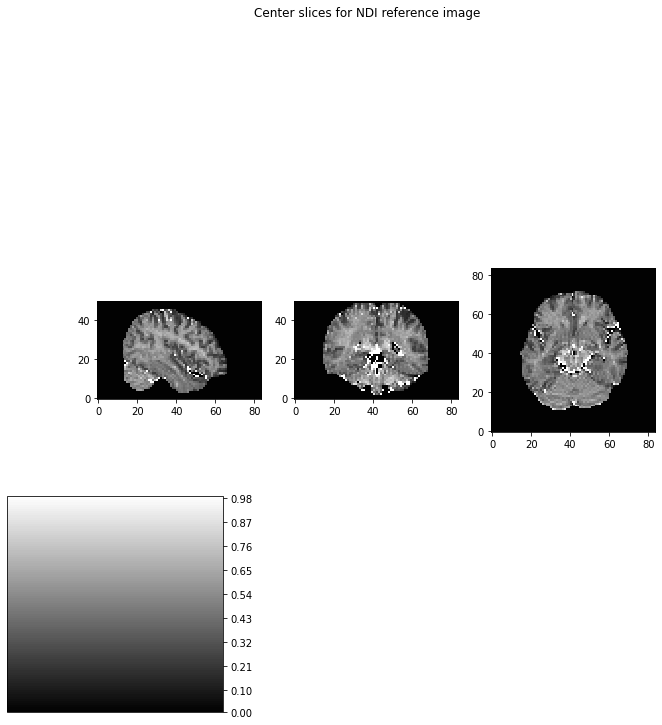

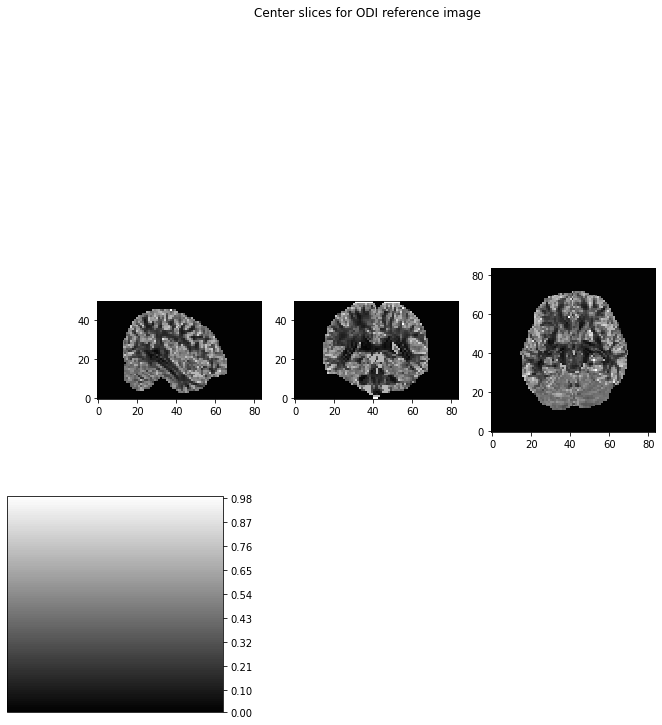

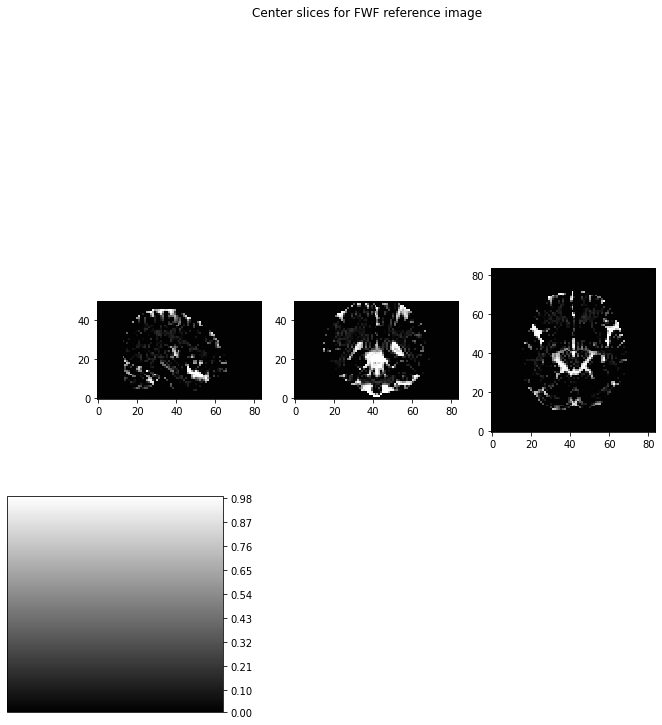

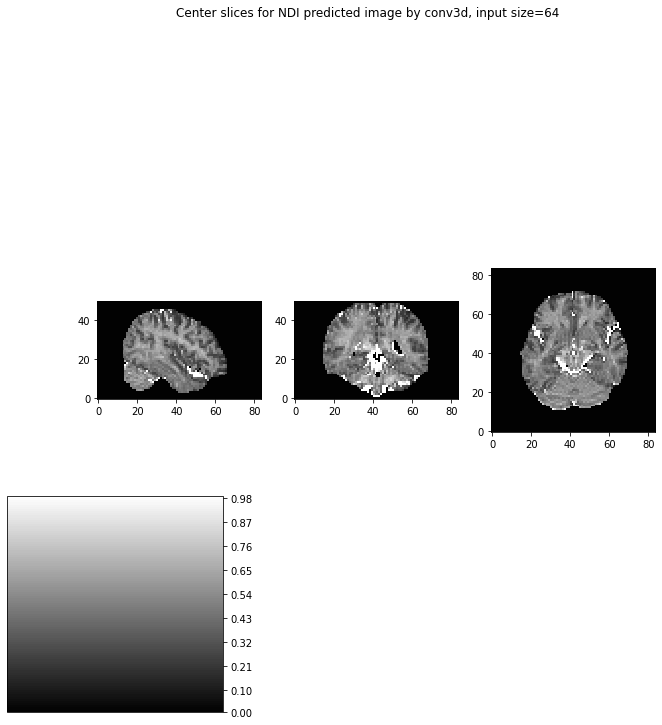

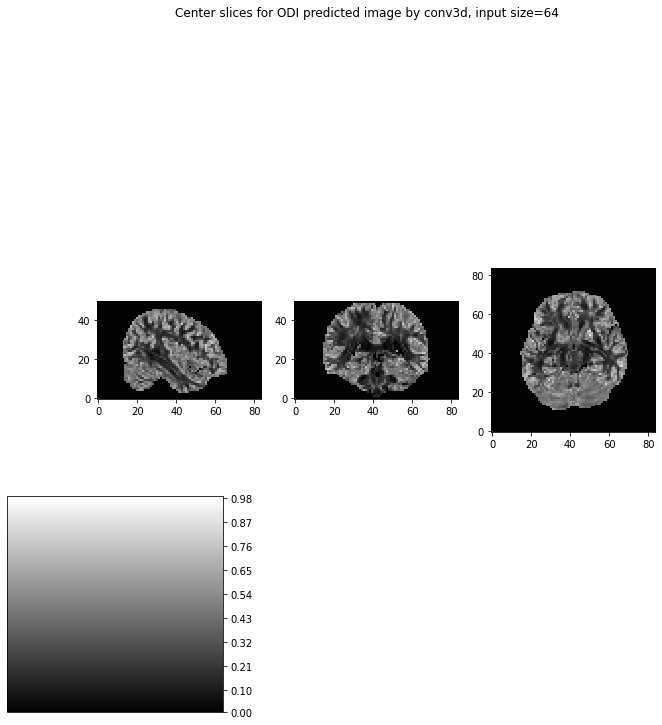

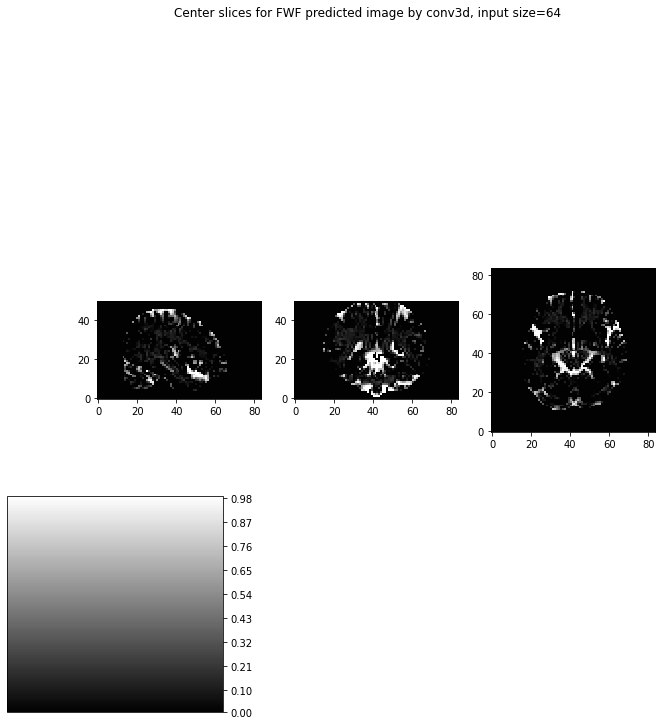

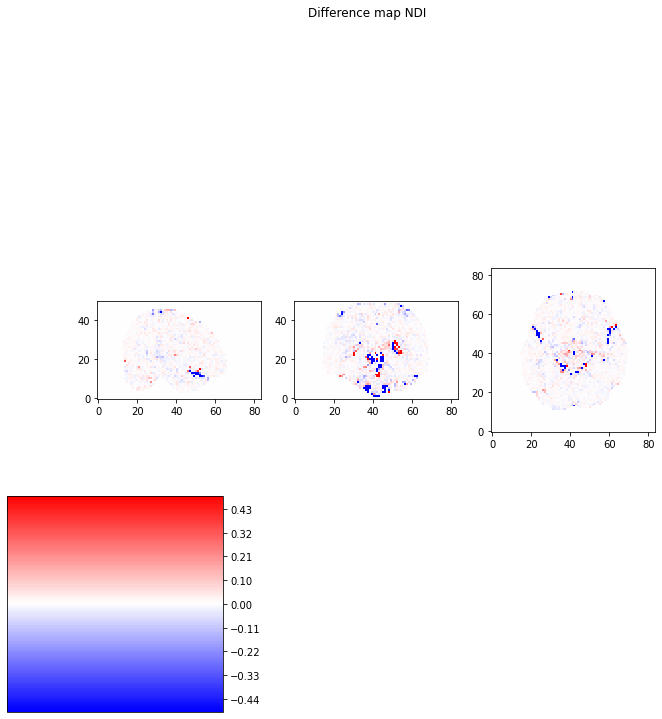

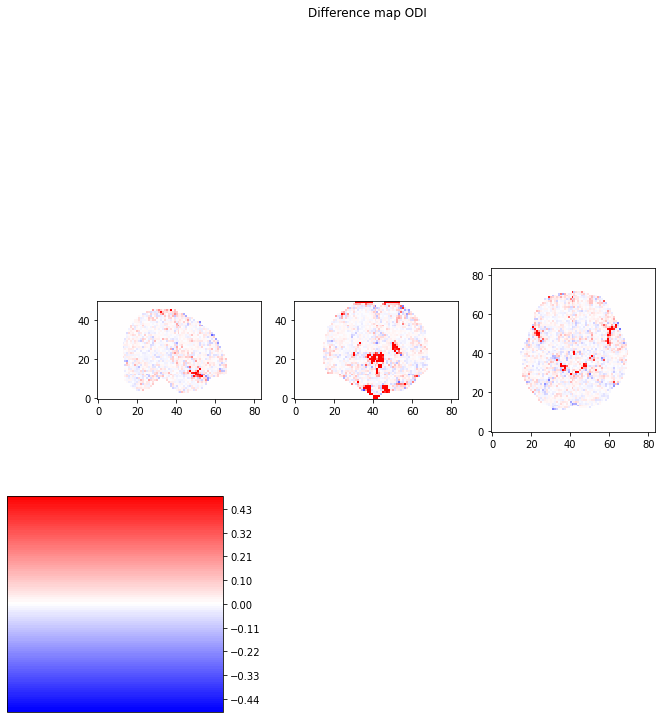

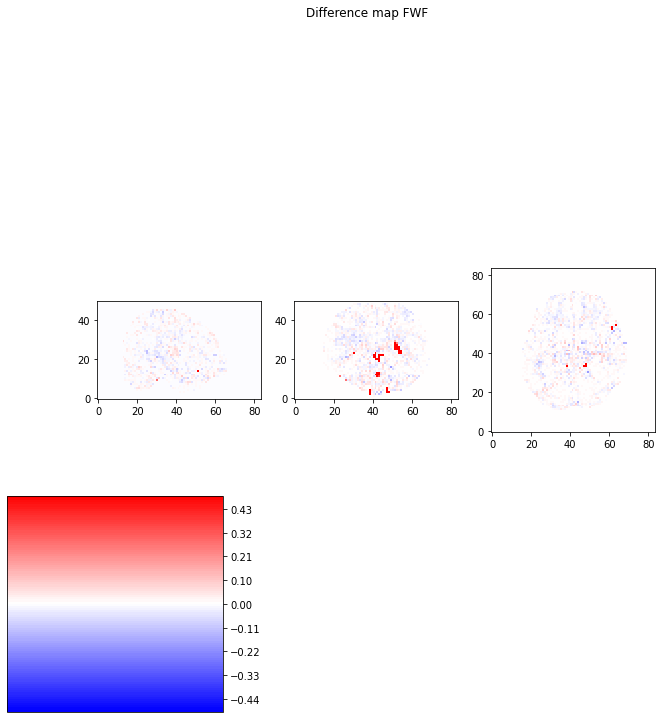

In [76]:
# visualise the predicted NODDI parameters
vol = 64 # the number of volumes remained after rejection scheme is applied
visualise(s04_NDI_img_data, s04_ODI_img_data, s04_FWF_img_data, retained_vol=vol,subject=study_subject, model=model, layer=layers, affine1=s04_NDI_affine, affine2=s04_ODI_affine, affine3=s04_FWF_affine)

___
<strong>AMICO</strong>

In [77]:
def writefile(path, file, scheme, savename):
    movefile = open(scheme, 'r')
    combine = np.array([int(num) for num in movefile.readline().split(' ')[:-1]])
    with open(path+savename, 'w') as fout:
        read_path = path+file
        read_file = open(read_path, 'r')
        lines = read_file.readlines()
        for line in lines:
            temp = line.split()
            temp = [e for e, b in zip(temp, combine) if b == 1]
            fout.write(' '.join(e for e in temp))
            fout.write('\n')
    fout.close()

def writediffusion(path, file, scheme):
    movefile = open(scheme, 'r')
    combine = np.array([int(num) for num in movefile.readline().split(' ')[:-1]])
    img = nib.load(path+file)
    data = img.get_fdata()
    data = data[..., combine==1]
    img = nib.Nifti1Image(data, np.eye(4))
    nib.save(img, path+'remained_diffusion')

In [78]:
# create the remained bvals and bvecs for s03 by applying its corresponding rejection scheme
s03_path = '/home/vw/Desktop/IndividualProject/MedICSS2021_/Data-NODDI/s03_motion/'
# write the remained bvals
writefile(s03_path, 'bvals', s03_movefile, savename='remained_bvals')
# write the remained bvecs
writefile(s03_path, 'bvecs', s03_movefile, savename='remained_bvecs')
# create the remained diffusion data
writediffusion(s03_path, 'diffusion.nii', s03_movefile)

In [79]:
amico.setup()
# generate a scheme file from the bvals/bvecs files as follows, using the remained bvals and bvecs. Because data rejection is applied
amico.util.fsl2scheme(s03_path+'remained_bvals', s03_path+'remained_bvecs')
ae = amico.Evaluation("/home/vw/Desktop/IndividualProject/MedICSS2021_/Data-NODDI", "s03_motion")
# load the data
ae.load_data(dwi_filename = "remained_diffusion.nii", scheme_filename = "remained_bvals.scheme", mask_filename = "mask-e.nii", b0_thr = 0)
# Set model for NODDI and generate the response functions for all the compartments:
ae.set_model("NODDI")
ae.generate_kernels()
ae.load_kernels()
# model fit. It takes a little time depending on the number of voxels (but much much faster than the original NODDI).
ae.fit()
# Finally, save the results as NIfTI images:
# ICVF = NDI
# ISOVF = FWF
# OD = ODI
ae.save_results()


-> Precomputing rotation matrices:


   |██████████████████████████████████████████████████████████| 100.0%

   [ DONE ]
-> Writing scheme file to [ /home/vw/Desktop/IndividualProject/MedICSS2021_/Data-NODDI/s03_motion/remained_bvals.scheme ]

-> Loading data:
	* DWI signal
		- dim    = 84 x 84 x 50 x 93
		- pixdim = 1.000 x 1.000 x 1.000
	* Acquisition scheme
		- 93 samples, 3 shells
		- 6 @ b=0 , 30 @ b=3000.0 , 29 @ b=1000.0 , 28 @ b=2000.0 
	* Binary mask
		- dim    = 84 x 84 x 50
		- pixdim = 2.500 x 2.500 x 2.500
		- voxels = 90772
   [ 0.1 seconds ]

-> Preprocessing:
	* Normalizing to b0... 

[ min=0.00,  mean=0.58, max=10986.17 ]
	* Keeping all b0 volume(s)
   [ 0.1 seconds ]

-> Creating LUT for "NODDI" model:
   [ LUT already computed. Use option "regenerate=True" to force regeneration ]

-> Resampling LUT for subject "s03_motion":


   |██████████████████████████████████████████████████████████| 100.0%


   [ 98.0 seconds ]

-> Fitting "NODDI" model to 90772 voxels:


   |██████████████████████████████████████████████████████████| 100.0%


   [ 00h 00m 36s ]

-> Saving output to "AMICO/NODDI/*":
	- configuration  [OK]
	- FIT_dir.nii.gz  [OK]
	- FIT_ICVF.nii.gz  [OK]
	- FIT_OD.nii.gz  [OK]
	- FIT_ISOVF.nii.gz  [OK]
   [ DONE ]


the ssim score for ndi is: 0.8849641570947171
the ssim score for odi is: 0.905620213270337
the ssim score for fwf is: 0.9277064082301237


Text(0.5, 0.98, 'ISOVF/FWF diff map')

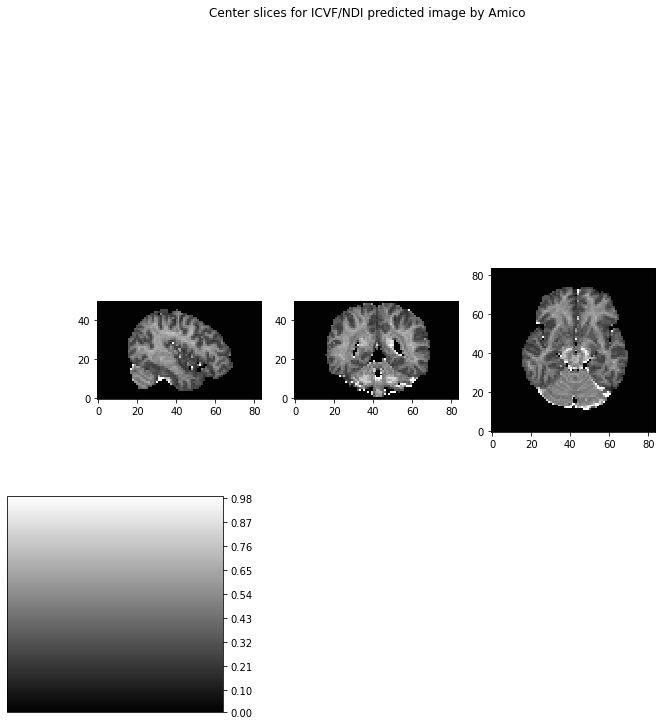

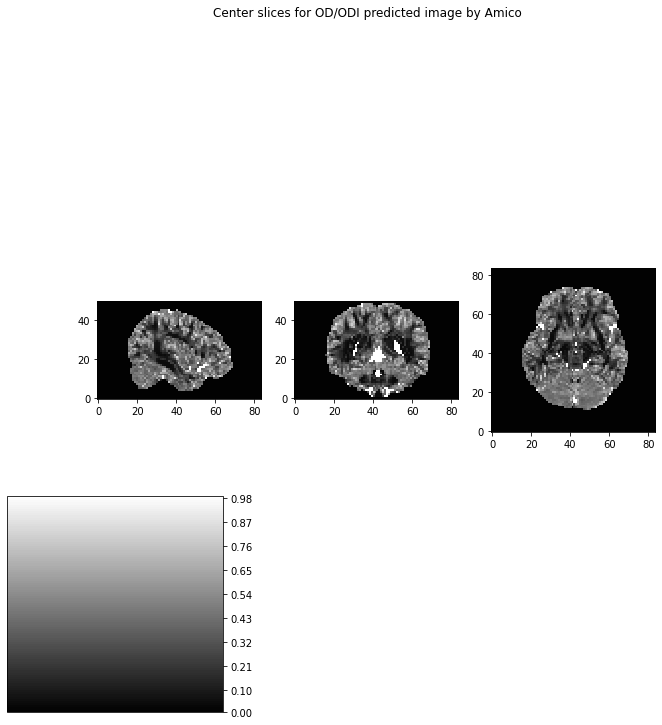

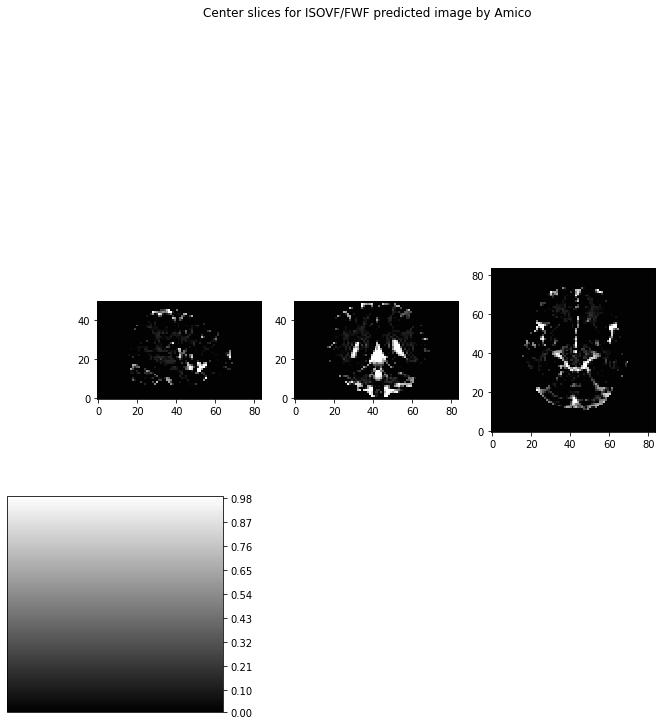

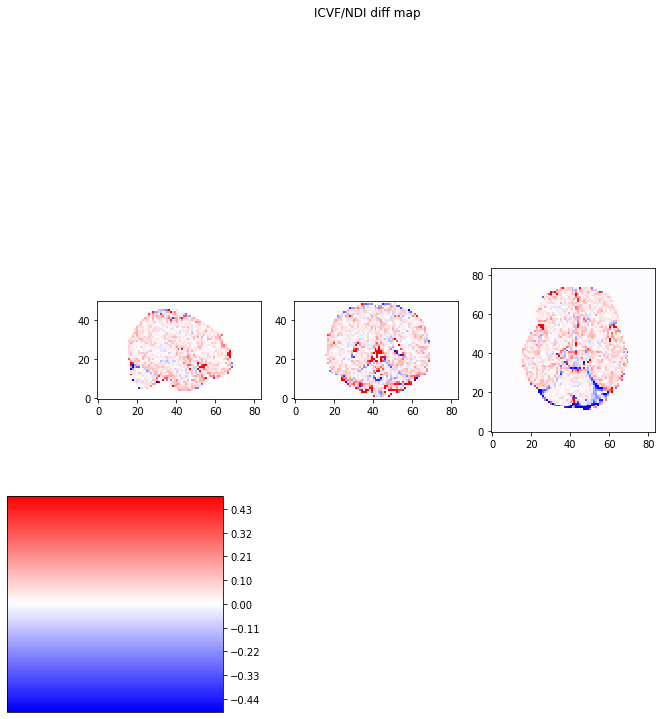

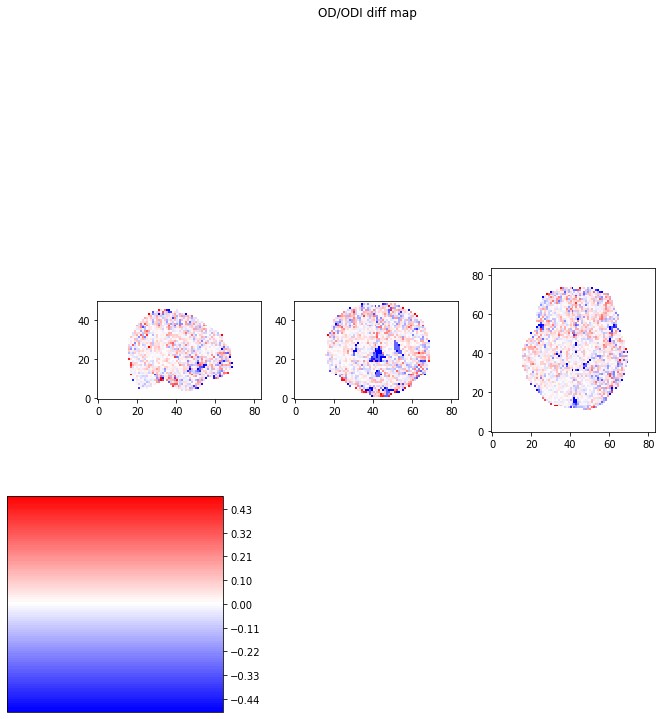

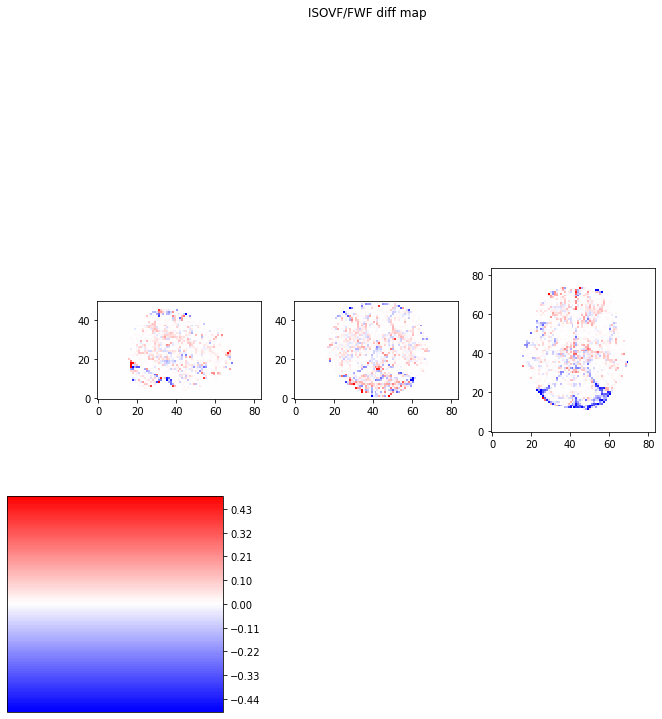

In [80]:
icvf_path = '/home/vw/Desktop/IndividualProject/MedICSS2021_/Data-NODDI/s03_motion/AMICO/NODDI/FIT_ICVF.nii.gz'
isovf_path = '/home/vw/Desktop/IndividualProject/MedICSS2021_/Data-NODDI/s03_motion/AMICO/NODDI/FIT_ISOVF.nii.gz'
od_path = '/home/vw/Desktop/IndividualProject/MedICSS2021_/Data-NODDI/s03_motion/AMICO/NODDI/FIT_OD.nii.gz'

icvf_img = nib.load(icvf_path)
icvf = icvf_img.get_fdata()
isovf_img = nib.load(isovf_path)
isovf = isovf_img.get_fdata()
od_img = nib.load(od_path)
od = od_img.get_fdata()

icvf0 = icvf[26, :, :]
icvf1 = icvf[:, 30, :]
icvf2 = icvf[:, :, 16]
show_slices([icvf0, icvf1, icvf2])
plt.suptitle("Center slices for ICVF/NDI predicted image by Amico")
(score, ndidiff) = compare_ssim(icvf, s03_NDI_img_data, full=True)
print('the ssim score for ndi is: ' + str(score))

od0 = od[26, :, :]
od1 = od[:, 30, :]
od2 = od[:, :, 16]
show_slices([od0, od1, od2])
plt.suptitle("Center slices for OD/ODI predicted image by Amico")
(score, ndidiff) = compare_ssim(od, s03_ODI_img_data, full=True)
print('the ssim score for odi is: ' + str(score))

isovf0 = isovf[26, :, :]
isovf1 = isovf[:, 30, :]
isovf2 = isovf[:, :, 16]
show_slices([isovf0, isovf1, isovf2])
plt.suptitle("Center slices for ISOVF/FWF predicted image by Amico")
(score, fwfdiff) = compare_ssim(isovf, s03_FWF_img_data, full=True)
print('the ssim score for fwf is: ' + str(score))

icvfdiff0 = scale(s03_NDI_img_data[26, :, :]-icvf0)
icvfdiff1 = scale(s03_NDI_img_data[:, 30, :]-icvf1)
icvfdiff2 = scale(s03_NDI_img_data[:, :, 16]-icvf2)
show_slices([icvfdiff0, icvfdiff1, icvfdiff2], grayscale=False)
plt.suptitle("ICVF/NDI diff map")

oddiff0 = scale(s03_ODI_img_data[26, :, :]-od0)
oddiff1 = scale(s03_ODI_img_data[:, 30, :]-od1)
oddiff2 = scale(s03_ODI_img_data[:, :, 16]-od2)
show_slices([oddiff0, oddiff1, oddiff2], grayscale=False)
plt.suptitle("OD/ODI diff map")

isovfdiff0 = scale(s03_FWF_img_data[26, :, :]-isovf0)
isovfdiff1 = scale(s03_FWF_img_data[:, 30, :]-isovf1)
isovfdiff2 = scale(s03_FWF_img_data[:, :, 16]-isovf2)
show_slices([isovfdiff0, isovfdiff1, isovfdiff2], grayscale=False)
plt.suptitle("ISOVF/FWF diff map")

In [81]:
# repeat the same process for subject 4
# create the remained bvals and bvecs for s04 by applying its corresponding rejection scheme
s04_path = '/home/vw/Desktop/IndividualProject/MedICSS2021_/Data-NODDI/s04_motion/'
# write the remained bvals
writefile(s04_path, 'bvals', s04_movefile, savename='remained_bvals')
# write the remained bvecs
writefile(s04_path, 'bvecs', s04_movefile, savename='remained_bvecs')
# create the remained diffusion data
writediffusion(s04_path, 'diffusion.nii', s04_movefile)

In [82]:
amico.setup()
# generate a scheme file from the bvals/bvecs files as follows, using the remained bvals and bvecs. Because data rejection is applied
amico.util.fsl2scheme(s04_path+'remained_bvals', s04_path+'remained_bvecs')
ae = amico.Evaluation("/home/vw/Desktop/IndividualProject/MedICSS2021_/Data-NODDI", "s04_motion")
# load the data
ae.load_data(dwi_filename = "remained_diffusion.nii", scheme_filename = "remained_bvals.scheme", mask_filename = "mask-e.nii", b0_thr = 0)
# Set model for NODDI and generate the response functions for all the compartments:
ae.set_model("NODDI")
ae.generate_kernels()
ae.load_kernels()
# model fit. It takes a little time depending on the number of voxels (but much much faster than the original NODDI).
ae.fit()
# Finally, save the results as NIfTI images:
# ICVF = NDI
# ISOVF = FWF
# OD = ODI
ae.save_results()


-> Precomputing rotation matrices:


   |██████████████████████████████████████████████████████████| 100.0%

   [ DONE ]
-> Writing scheme file to [ /home/vw/Desktop/IndividualProject/MedICSS2021_/Data-NODDI/s04_motion/remained_bvals.scheme ]

-> Loading data:
	* DWI signal
		- dim    = 84 x 84 x 50 x 64
		- pixdim = 1.000 x 1.000 x 1.000
	* Acquisition scheme
		- 64 samples, 3 shells
		- 4 @ b=0 , 17 @ b=3000.0 , 21 @ b=1000.0 , 22 @ b=2000.0 
	* Binary mask
		- dim    = 84 x 84 x 50
		- pixdim = 2.500 x 2.500 x 2.500
		- voxels = 88022
   [ 0.0 seconds ]

-> Preprocessing:
	* Normalizing to b0... 

[ min=0.00,  mean=0.48, max=373.01 ]
	* Keeping all b0 volume(s)
   [ 0.1 seconds ]

-> Creating LUT for "NODDI" model:
   [ LUT already computed. Use option "regenerate=True" to force regeneration ]

-> Resampling LUT for subject "s04_motion":


   |██████████████████████████████████████████████████████████| 100.0%


   [ 79.6 seconds ]

-> Fitting "NODDI" model to 88022 voxels:


   |██████████████████████████████████████████████████████████| 100.0%


   [ 00h 00m 31s ]

-> Saving output to "AMICO/NODDI/*":
	- configuration  [OK]
	- FIT_dir.nii.gz  [OK]
	- FIT_ICVF.nii.gz  [OK]
	- FIT_OD.nii.gz  [OK]
	- FIT_ISOVF.nii.gz  [OK]
   [ DONE ]


the ssim score for ndi is: 0.8031558215823659
the ssim score for odi is: 0.83262652087908
the ssim score for fwf is: 0.8043975373293152


Text(0.5, 0.98, 'ISOVF/FWF diff map')

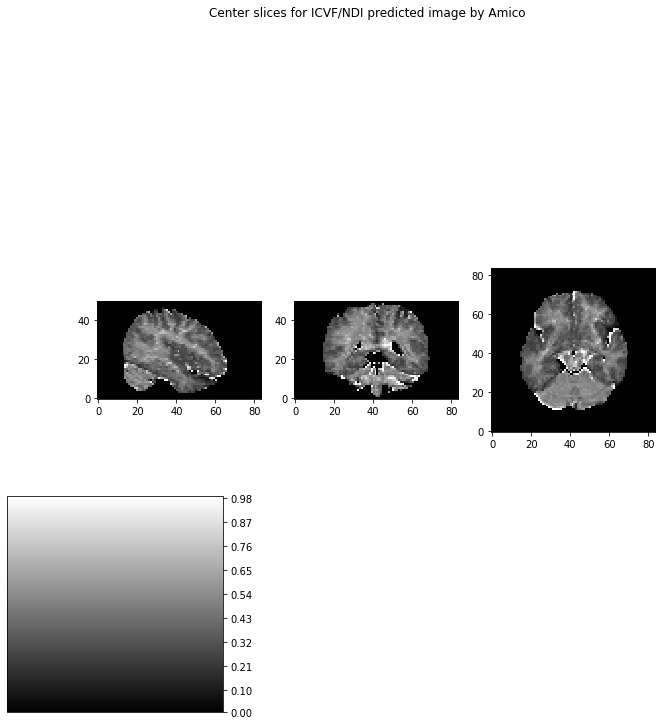

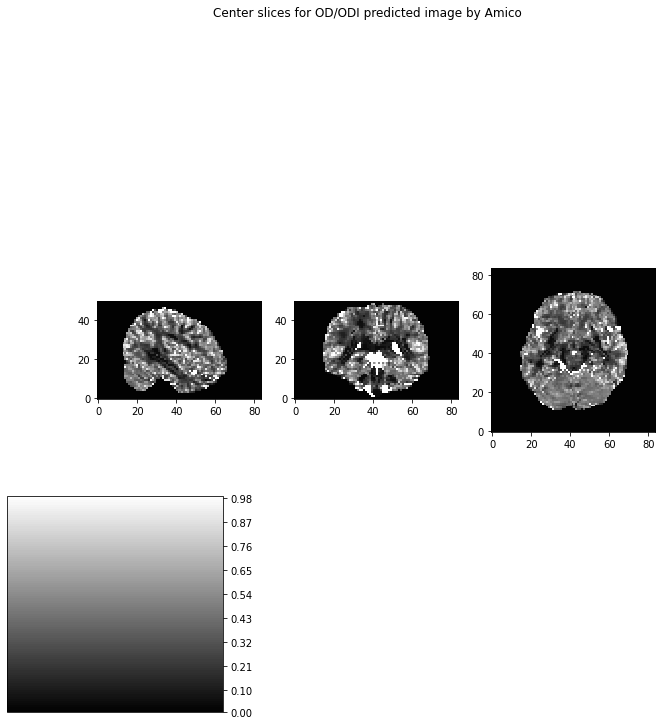

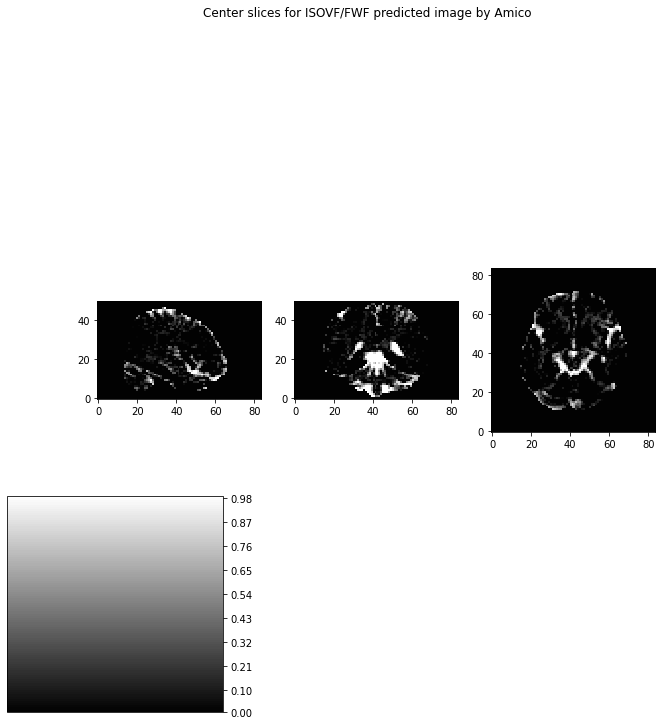

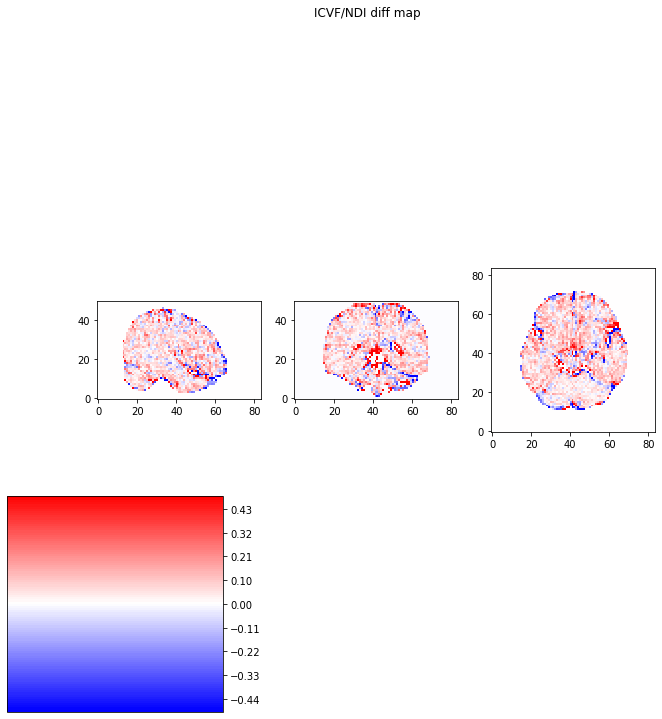

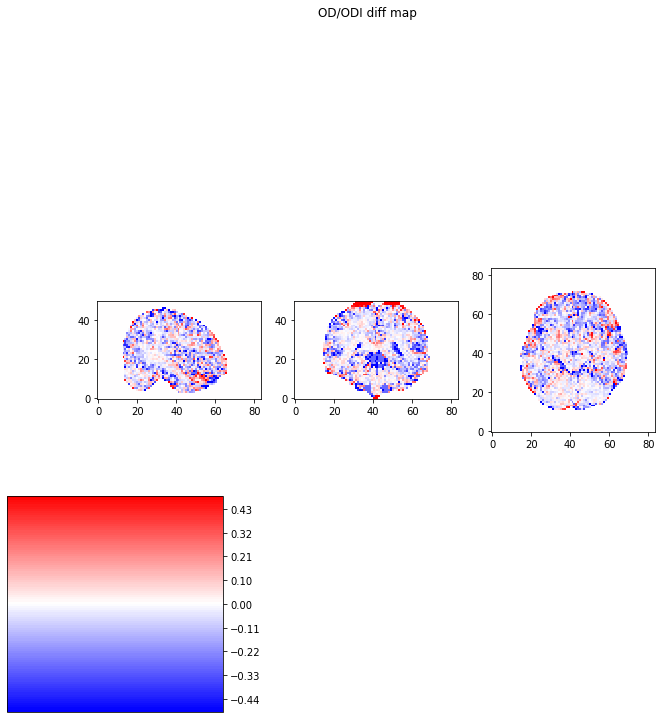

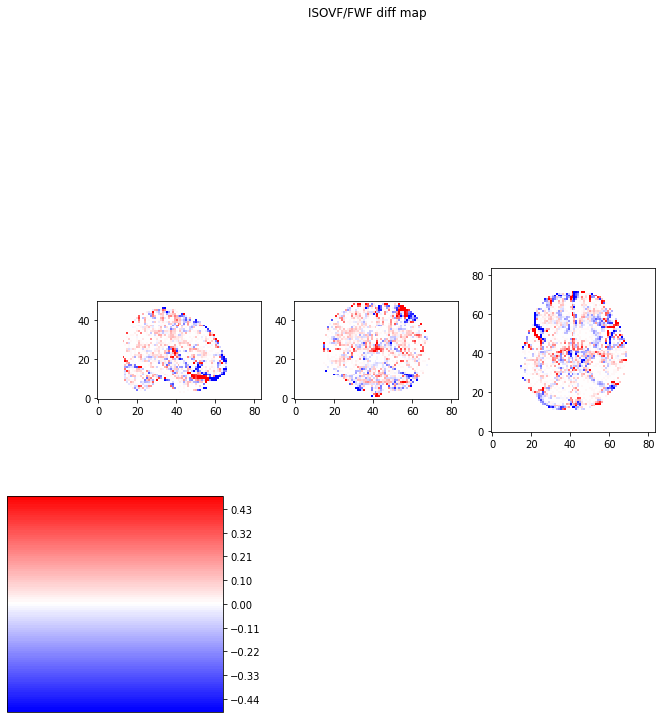

In [83]:
icvf_path = '/home/vw/Desktop/IndividualProject/MedICSS2021_/Data-NODDI/s04_motion/AMICO/NODDI/FIT_ICVF.nii.gz'
isovf_path = '/home/vw/Desktop/IndividualProject/MedICSS2021_/Data-NODDI/s04_motion/AMICO/NODDI/FIT_ISOVF.nii.gz'
od_path = '/home/vw/Desktop/IndividualProject/MedICSS2021_/Data-NODDI/s04_motion/AMICO/NODDI/FIT_OD.nii.gz'

icvf_img = nib.load(icvf_path)
icvf = icvf_img.get_fdata()
isovf_img = nib.load(isovf_path)
isovf = isovf_img.get_fdata()
od_img = nib.load(od_path)
od = od_img.get_fdata()

icvf0 = icvf[26, :, :]
icvf1 = icvf[:, 30, :]
icvf2 = icvf[:, :, 16]
show_slices([icvf0, icvf1, icvf2])
plt.suptitle("Center slices for ICVF/NDI predicted image by Amico")
(score, ndidiff) = compare_ssim(icvf, s04_NDI_img_data, full=True)
print('the ssim score for ndi is: ' + str(score))

od0 = od[26, :, :]
od1 = od[:, 30, :]
od2 = od[:, :, 16]
show_slices([od0, od1, od2])
plt.suptitle("Center slices for OD/ODI predicted image by Amico")
(score, ndidiff) = compare_ssim(od, s04_ODI_img_data, full=True)
print('the ssim score for odi is: ' + str(score))

isovf0 = isovf[26, :, :]
isovf1 = isovf[:, 30, :]
isovf2 = isovf[:, :, 16]
show_slices([isovf0, isovf1, isovf2])
plt.suptitle("Center slices for ISOVF/FWF predicted image by Amico")
(score, fwfdiff) = compare_ssim(isovf, s04_FWF_img_data, full=True)
print('the ssim score for fwf is: ' + str(score))

icvfdiff0 = scale(s04_NDI_img_data[26, :, :]-icvf0)
icvfdiff1 = scale(s04_NDI_img_data[:, 30, :]-icvf1)
icvfdiff2 = scale(s04_NDI_img_data[:, :, 16]-icvf2)
show_slices([icvfdiff0, icvfdiff1, icvfdiff2], grayscale=False)
plt.suptitle("ICVF/NDI diff map")

oddiff0 = scale(s04_ODI_img_data[26, :, :]-od0)
oddiff1 = scale(s04_ODI_img_data[:, 30, :]-od1)
oddiff2 = scale(s04_ODI_img_data[:, :, 16]-od2)
show_slices([oddiff0, oddiff1, oddiff2], grayscale=False)
plt.suptitle("OD/ODI diff map")

isovfdiff0 = scale(s04_FWF_img_data[26, :, :]-isovf0)
isovfdiff1 = scale(s04_FWF_img_data[:, 30, :]-isovf1)
isovfdiff2 = scale(s04_FWF_img_data[:, :, 16]-isovf2)
show_slices([isovfdiff0, isovfdiff1, isovfdiff2], grayscale=False)
plt.suptitle("ISOVF/FWF diff map")